# PCA and LDA comparison

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.sparse
import scipy.sparse.linalg
import math
from tqdm import tqdm

The task for this exercise is to compare PCA and LDA in their ability to cluster when projecting very high-dimensional datapoints to 2 or 3 dimensions. In particular, consider the dataset MNIST provided on Virtuale. This dataset contains images of handwritten digits with dimension $28×28$, together with a number from 0 to 9 representing the label. You are asked to:

1) Load the dataset in memory and explore its head and shape to understand how the informations are placed inside of it;


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/datasets/homework2SMAAIdata.csv")

data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


2) Split the dataset into the X matrix of dimension $d × N$, with $d = 784$ being the dimension of each datum, N is the number of datapoints, and $Y ∈ ℝ^N$ containing the corresponding labels;

In [ ]:
data = np.array(data)
X = np.transpose(data[:,1:])
Y = np.copy(data[:,0])

print("X shape: ", X.shape)
print("Y shape: ", Y.shape)

X shape:  (784, 42000)
Y shape:  (42000,)


3) Choose a number of digits (for example, 0, 6 and 9) and extract from X and Y the sub-dataset containing only the considered digits. Re-call X and Y those datasets, since the originals are not required anymore;

In [ ]:
labels = [0,6,9]

X = np.array(X[:, np.isin(Y, labels)])
Y = np.array([y for y in Y if y in labels])

print("New X shape: ", X.shape)
print("New Y shape: ", Y.shape)

New X shape:  (784, 12457)
New Y shape:  (12457,)


4) Set $N_{train} < N$ and randomly sample a training set with $N_{train}$ datapoints from X (and the corresponding Y). Call them $X_{train}$ and $Y_{train}$. Everything else is the test set. Call it $X_{test}$ and $Y_{test}$.

In [ ]:
def split_data(X, Y, train_size = 0.8):
  N_train = int(len(Y)*train_size)
  pixels_per_image, images = X.shape
  idx = np.arange(images)
  np.random.shuffle(idx)

  train_idx = idx[0:N_train]
  test_idx = idx[N_train:-1]

  X_train = X[:, train_idx]
  Y_train = Y[train_idx]

  X_test = X[:, test_idx]
  Y_test = Y[test_idx]

  return (X_train, Y_train), (X_test, Y_test)

train_size = 0.8
(X_train, Y_train), (X_test, Y_test) = split_data(X, Y, train_size)

print("X_train shape: ", X_train.shape, "   //    Y_train shape: ", Y_train.shape)
print("\nX_test shape: ", X_test.shape, "   //    Y_test shape: ", Y_test.shape)

X_train shape:  (784, 9965)    //    Y_train shape:  (9965,)

X_test shape:  (784, 2491)    //    Y_test shape:  (2491,)


5) Implement the algorithms computing the PCA and LDA of $X_{train}$ with a fixed $k$. Visualize the results (for $k = 2$) and the position of the centroid of each cluster;

In [ ]:
# plot function for both PCA and LDA
def plot_dimensionality_reduction(X, Y, labels, title, k = 2):
  if k == 2:
    for label, color in zip(labels, ['blue', 'green', 'red']):
      plt.scatter(X[0, Y == label], X[1, Y == label], c=color, label=f'{label}')

    centroids = {label: np.mean(X[:, Y == label], axis=1) for label in labels}
    for label in labels:
      plt.scatter(centroids[label][0], centroids[label][1], c="black", marker='x')

  elif k == 3:
    ax = plt.axes(projection='3d')
    for label, color in zip(labels, ['blue', 'green', 'red']):
      ax.scatter(X[0, Y == label], X[1, Y == label], X[2, Y == label], c=color, label=f'{label}')

    centroids = {label: np.mean(X[:, Y == label], axis=1) for label in labels}

    for label in labels:
      ax.scatter(centroids[label][0], centroids[label][1], c="black", marker='x')

  plt.legend()
  plt.title(title)
  plt.show()

# plot heatmaps for comparison PCA vs LDA with different triplets of digits and Ks
def plot_heatmaps(accuracies_pca, accuracies_lda, label_triplets, k_to_test):
    n_triplets = len(label_triplets)
    n_k_values = len(k_to_test)

    # Preparing data for the heatmaps
    data_pca = np.zeros((n_triplets, n_k_values))
    data_lda = np.zeros((n_triplets, n_k_values))
    for i, labels in enumerate(label_triplets):
        for j, k in enumerate(k_to_test):
            data_pca[i, j] = accuracies_pca[tuple(labels)][j]
            data_lda[i, j] = accuracies_lda[tuple(labels)][j]

    plt.figure(figsize=(20, 6))

    # PCA heatmap
    plt.subplot(1, 2, 1)
    sns.heatmap(data_pca, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=k_to_test, yticklabels=label_triplets)
    plt.title('PCA Accuracies for Different Label Triplets and k values')
    plt.xlabel('Number of PCA Components (k)')
    plt.ylabel('Label Triplets')

    # LDA heatmap
    plt.subplot(1, 2, 2)
    sns.heatmap(data_lda, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=k_to_test, yticklabels=label_triplets)
    plt.title('LDA Accuracies for Different Label Triplets and k values')
    plt.xlabel('Number of LDA Components (k)')
    plt.ylabel('Label Triplets')

    plt.tight_layout()
    plt.show()


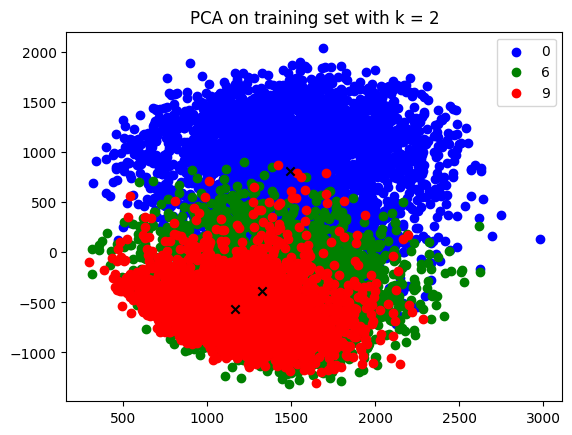

In [ ]:
def PCA(X, k=2):
  # shifting the data so that the global centroid is in (0,0)
  mean = np.mean(X, axis=0)
  X_centered = X - mean.T

  # computing SVD
  U, s, VT = np.linalg.svd(X_centered, full_matrices=False)

  P = U[:, :k].T      # Projection operator -> U represents the matrix of eigenvectors (or principal components) of the covariance matrix of the data
  Z = P @ X_centered  # X projected

  return Z, P


# Plot the PCA results (2D or 3D)
k = 2
Z_pca, P = PCA(X_train, k)
plot_dimensionality_reduction(Z_pca, Y_train, labels, f"PCA on training set with k = {k}", k)

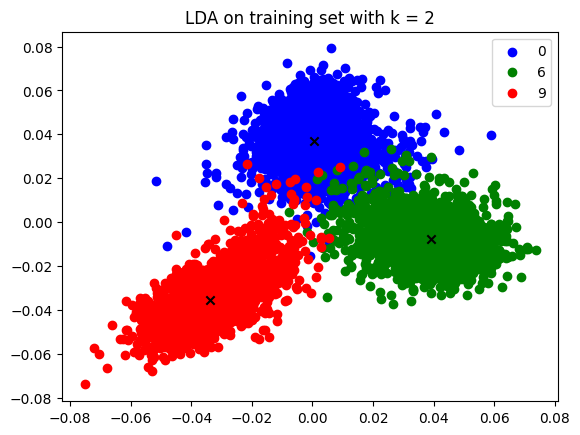

In [ ]:
def LDA(X, Y, k=2):
    labels = np.unique(Y)
    num_classes = len(labels)
    d = X.shape[0]

    global_centroid = np.mean(X, axis=1)
    class_centroids = {label: np.mean(X[:, Y == label], axis=1) for label in labels}

    # move data so that each class's data points are shifted by their respective class centroids
    X_centered = {label: X[:, Y == label] - class_centroids[label].reshape((d, 1)) for label in labels}

    # Within-cluster scatter matrix (correlation matrix of points belonging to same class)
    Xw = np.concatenate([X_centered[label] for label in labels], axis=1)
    Sw = Xw @ Xw.T

    # Between-cluster scatter matrix (correlation matrix of points belonging to different classes)
    Xbars = [np.repeat(class_centroids[label].reshape(d, 1), X_centered[label].shape[1], axis=1) for label in labels]
    Xbar = np.concatenate(Xbars, axis=1)

    Xbar_c = Xbar - global_centroid.reshape((d, 1))
    Sb = Xbar_c @ Xbar_c.T

    # Cholesky decomposition of Sw
    try:
        L = np.linalg.cholesky(Sw)
    except:
        epsilon = 1e-6
        Sw = Sw + epsilon * np.eye(Sw.shape[0])
        L = np.linalg.cholesky(Sw)

    # First k eigenvector decomposition of (L^-1 @ Sb @ L), identifies the most discriminative directions in the transformed space.
    _, W = scipy.sparse.linalg.eigs(np.linalg.inv(L) @ Sb @ L, k)
    W = np.real(W)

    # Compute Q
    Q = (np.linalg.inv(L).T @ W).T  # Projection matrix
    Z = Q @ X                       # X projected

    return Z, Q


# Plot the LDA results (2D or 3D)
Z_lda, Q = LDA(X_train, Y_train)
k = 2
plot_dimensionality_reduction(Z_lda, Y_train, labels, f"LDA on training set with k = {k}", k)

**Clustering capabilities**

- PCA aims to reduce the dimensionality of data by finding a set of principal components that capture the maximum variance in the data without considering any class labels (unsupervised). When performing clustering, PCA may not always be effective if the variance is not aligned with class separations since the principal components are selected irrespective of the class distinction, which might lead to mixed clusters if the class separation is not along the major variance directions.
- LDA aims to find a linear combination of features that separates the instances of several classes. It uses class labels to guide the dimensionality reduction (supervised). It focuses on maximizing the between-cluster distance and minimizing the within-cluster distance therefore, enhancing the class separability (better approach if the goal is clustering and classes are given).


6) For both the algorithms, compute for each cluster the average distance from the centroid. Comment the result;

In [ ]:
# average distance for PCA (training set)
centroids_pca = {label: np.mean(Z_pca[:, Y_train == label], axis=1) for label in labels}

print("#########  PCA: average distance on the training set  #########")
for label in labels:
  average_dist = 0
  for i in range(Z_pca.shape[1]):
    average_dist += math.dist(centroids_pca[label], Z_pca[:, i])
  average_dist = average_dist/Z_pca.shape[1]
  print(f"For data with label {label} the average distance from the centroid is: {average_dist}")


# average distance for LDA (training set)
centroids_lda = {label: np.mean(Z_lda[:, Y_train == label], axis=1) for label in labels}

print("\n#########  LDA: average distance on the training set  #########")
for label in labels:
  average_dist = 0
  for i in range(Z_lda.shape[1]):
    average_dist += math.dist(centroids_lda[label], Z_lda[:, i])
  average_dist = average_dist/Z_lda.shape[1]
  print(f"For data with label {label} the average distance from the centroid is: {average_dist}")

#########  PCA: average distance on the training set  #########
For data with label 0 the average distance from the centroid is: 1113.340188292033
For data with label 6 the average distance from the centroid is: 731.2817476562915
For data with label 9 the average distance from the centroid is: 777.1035908628912

#########  LDA: average distance on the training set  #########
For data with label 0 the average distance from the centroid is: 0.05100725917004055
For data with label 6 the average distance from the centroid is: 0.050108468692014255
For data with label 9 the average distance from the centroid is: 0.056907073362453785


7. For both the algorithms, compute for each cluster the average distance from the centroid on the test set. Comment the results;

In [ ]:
# average distance for PCA (test set)
Z_pca_test, P_test = PCA(X_test)
centroids_pca = {label: np.mean(Z_pca_test[:, Y_test == label], axis=1) for label in labels}
print("#########  PCA: average distance on the test set  #########")
for label in labels:
  average_dist = 0
  for i in range(Z_pca_test.shape[1]):
    average_dist += math.dist(centroids_pca[label], Z_pca_test[:, i])
  average_dist = average_dist/Z_pca_test.shape[1]
  print(f"For data with label {label} the average distance from the centroid is: {average_dist}")

# average distance for LDA (test set)
Z_lda_test, Q_test = LDA(X_test, Y_test)
centroids_lda = {label: np.mean(Z_lda_test[:, Y_test == label], axis=1) for label in labels}
print("\n#########  LDA: average distance on the test set  #########")
for label in labels:
  average_dist = 0
  for i in range(Z_lda_test.shape[1]):
    average_dist += math.dist(centroids_lda[label], Z_lda_test[:, i])
  average_dist = average_dist/Z_lda_test.shape[1]
  print(f"For data with label {label} the average distance from the centroid is: {average_dist}")


#########  PCA: average distance on the test set  #########
For data with label 0 the average distance from the centroid is: 1099.691217838738
For data with label 6 the average distance from the centroid is: 727.6612138608531
For data with label 9 the average distance from the centroid is: 770.790051915923

#########  LDA: average distance on the test set  #########
For data with label 0 the average distance from the centroid is: 0.11269033540599736
For data with label 6 the average distance from the centroid is: 0.1111534056959871
For data with label 9 the average distance from the centroid is: 0.12425057648484586


For both training and test set, there is a big difference in the order of magnitude of the values reported for PCA and LDA, it reflects the fundamental differences in how these two techniques approach dimensionality reduction and data representation:
-	PCA: The high values are due to its variance-preserving nature, which can lead to larger spreads in data points, especially in datasets where the variance is high.
-	LDA: The low values reflect its ability to compress data points of the same class, leading to a much tighter cluster around the centroid of each class.


8. Define a classification algorithm in this way: given a new observation x, compute the distance between x and each cluster centroid. Assign x to the class corresponding the the closer centroid. Compute the accuracy of this algorithm on the test set and compute its accuracy for both PCA and LDA;


In [ ]:
# given a single of observations X and the centroids on a projected space, return the classification of X
def classify(projection_matrix, x, centroids):
  distances = {}
  z = projection_matrix @ x

  for label in centroids.keys():
    distances[label] = np.linalg.norm(z-centroids[label])

  min_value = float('inf')  # Set to positive infinity to ensure any value is smaller
  min_key = None

  for key, value in distances.items():
    if value < min_value:
        min_key = key
        min_value = value

  return min_key

# return the accuracy of the classification of a set of observations
def accuracy(projection_matrix, centroids, X, Y):
  accuracy = 0

  for i in range(X.shape[1]):
   accuracy += (1 if classify(projection_matrix, X[:,i], centroids) == Y[i] else 0)

  accuracy = accuracy / X.shape[1]

  return accuracy*100 #return percentage

In [ ]:
#pca classification
Z_pca, P = PCA(X_train)
centroids_pca = {label: np.mean(Z_pca[:, Y_train == label], axis=1) for label in labels}
acc_pca = accuracy(P, centroids_pca, X_test, Y_test)

#lda classification
Z_lda, Q = LDA(X_train, Y_train)
centroids_lda = {label: np.mean(Z_lda[:, Y_train == label], axis=1) for label in labels}
acc_lda = accuracy(Q, centroids_lda, X_test, Y_test)

#print accuracy
print(f"The accuracy on the test set of PCA is: {round(acc_pca,2)}%")
print(f"The accuracy on the test set of LDA is: {round(acc_lda,2)}%")

The accuracy on the test set of PCA is: 70.77%
The accuracy on the test set of LDA is: 97.71%


Here we classify new observations based on their proximity to the centroids of known classes in the space. For $K = 2$:
- PCA: the fact that it mostly focuses on the data variance without considering class labels leads to lower accuracy (this problem could be contained if class separability was along the principal components).

- LDA, being class-conscious and aiming to maximize class separability, yields higher classification accuracy compared to PCA.


9. Repeat this experiment for different values of k and different digits. What do you observe?

In [ ]:
def create_dataset(labels):
  X = np.transpose(data[:,1:])
  Y = data[:,0]
  X = np.array(X[:,np.isin(Y, labels)])
  Y = np.array([y for y in Y if y in labels])

  return split_data(X, Y)

Processing k values for labels [6, 7, 8]: 100%|██████████| 8/8 [01:00<00:00,  7.60s/it]


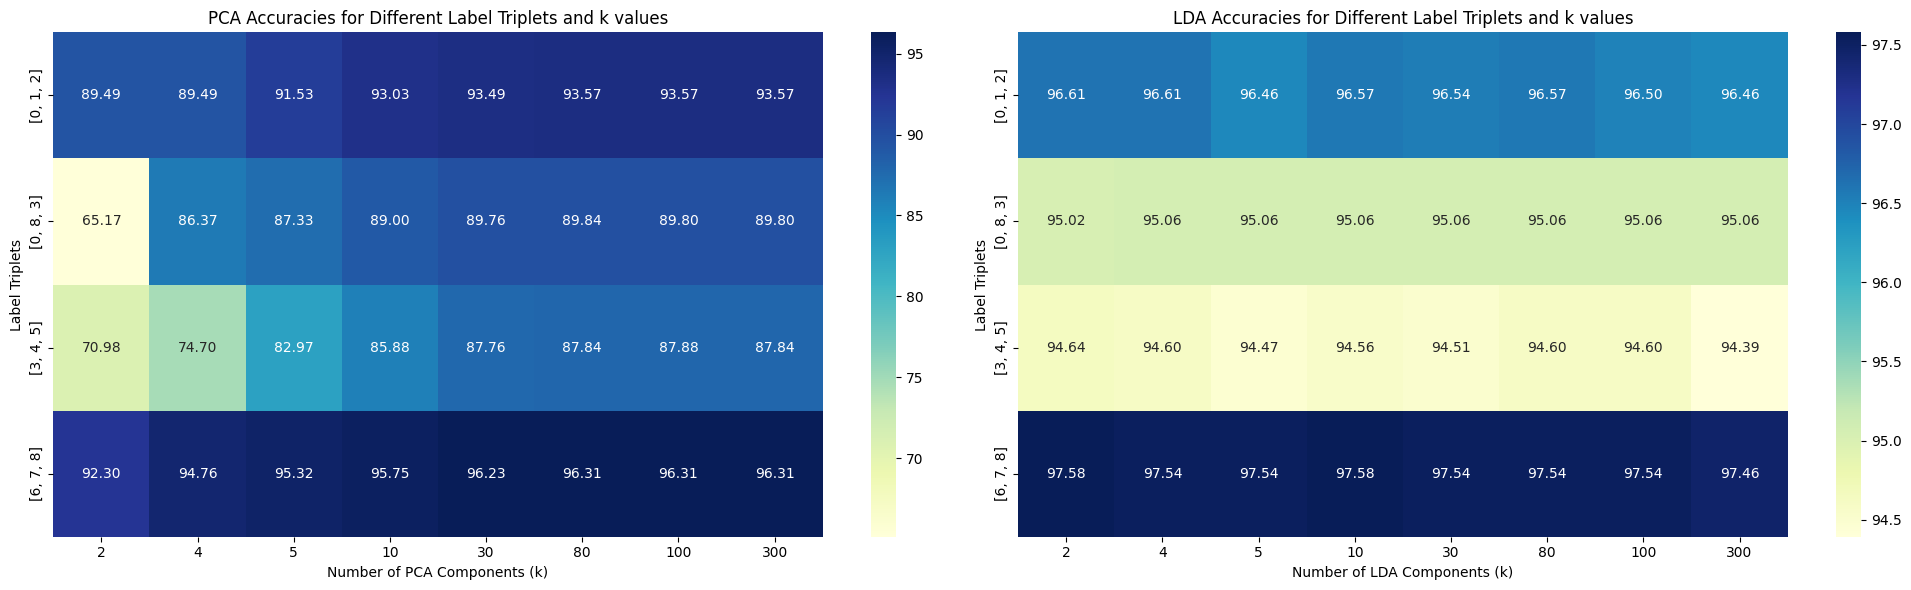

In [ ]:
label_triplets = [[0, 1, 2], [0, 8, 3], [3, 4, 5], [6, 7, 8]]
k_to_test = [2, 4, 5, 10, 30, 80, 100, 300]

accuracies_pca = {tuple(label): [] for label in label_triplets}
accuracies_lda = {tuple(label): [] for label in label_triplets}

for labels in label_triplets:
    (X_train, Y_train), (X_test, Y_test) = create_dataset(labels)

    for k in tqdm(k_to_test, desc=f"Processing k values for labels {labels}"):
        # PCA classification
        Z_pca, P = PCA(X_train, k)
        centroids_pca = {label: np.mean(Z_pca[:, Y_train == label], axis=1) for label in labels}
        acc_pca = accuracy(P, centroids_pca, X_test, Y_test)

        # LDA classification
        Z_lda, Q = LDA(X_train, Y_train, k)
        centroids_lda = {label: np.mean(Z_lda[:, Y_train == label], axis=1) for label in labels}
        acc_lda = accuracy(Q, centroids_lda, X_test, Y_test)

        # Store accuracies
        accuracies_pca[tuple(labels)].append(acc_pca)
        accuracies_lda[tuple(labels)].append(acc_lda)

print()
plot_heatmaps(accuracies_pca, accuracies_lda, label_triplets, k_to_test)

Observations:
- PCA: Initially, as you increase the number of principal components, the accuracy of the classifier increases until an optimal point is met, and the accuracy stays stable. This is because more principal components capture more variance in the data, providing a more comprehensive representation of the dataset.

- LDA: Unlike PCA, the maximum number of discriminants in LDA is inherently limited to the number of classes minus one. LDA tries to find the directions in which the classes are best separated. However, since each class can only be separated from the others in terms of relative position, the maximum number of independent directions that provide meaningful separation is $C-1$. Hence, as we can observe, the optimal performance in LDA is achieved when all available discriminants are used (2 in this case).

## Comparison with GD and SGD (from homework 3)

Processing k values for labels [8, 9]: 100%|██████████| 7/7 [00:45<00:00,  6.55s/it]


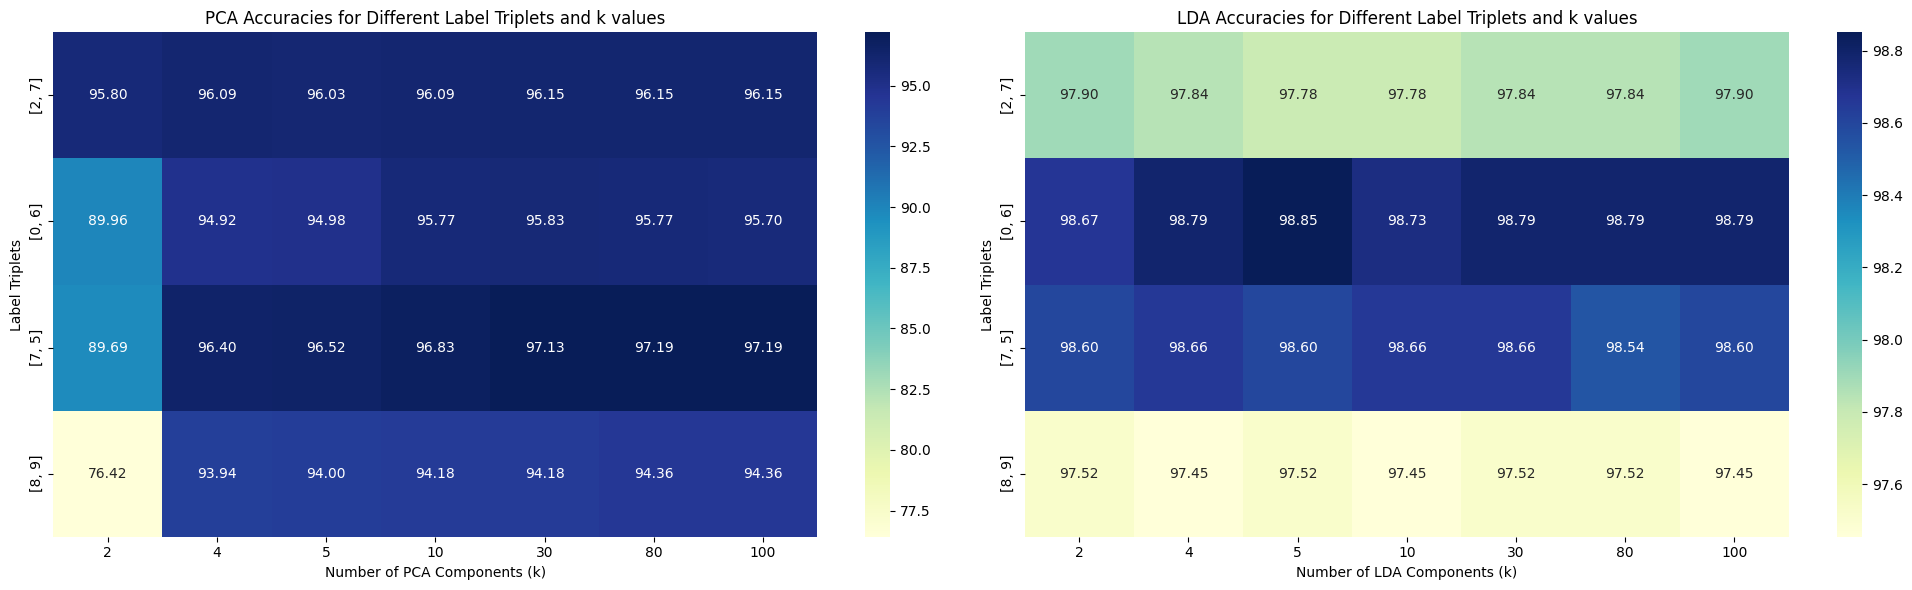

In [ ]:
label_tuples = [[2,7], [0, 6], [7, 5], [8, 9]]
k_to_test = [2, 4, 5, 10, 30, 80, 100]

accuracies_pca = {tuple(label): [] for label in label_tuples}
accuracies_lda = {tuple(label): [] for label in label_tuples}

for labels in label_tuples:
    (X_train, Y_train), (X_test, Y_test) = create_dataset(labels)

    for k in tqdm(k_to_test, desc=f"Processing k values for labels {labels}"):
        # PCA classification
        Z_pca, P = PCA(X_train, k)
        centroids_pca = {label: np.mean(Z_pca[:, Y_train == label], axis=1) for label in labels}
        acc_pca = accuracy(P, centroids_pca, X_test, Y_test)

        # LDA classification
        Z_lda, Q = LDA(X_train, Y_train, k)
        centroids_lda = {label: np.mean(Z_lda[:, Y_train == label], axis=1) for label in labels}
        acc_lda = accuracy(Q, centroids_lda, X_test, Y_test)

        # Store accuracies
        accuracies_pca[tuple(labels)].append(acc_pca)
        accuracies_lda[tuple(labels)].append(acc_lda)

print()
plot_heatmaps(accuracies_pca, accuracies_lda, label_tuples, k_to_test)

Lower values with respect to both GD and SGD

# Visualizing dyad
 Consider an image from skimage.data. For simplicity, say that $X \in ℝ^{m*n}$ is the matrix representing that image. You are asked to visualize the dyad of the SVD Decomposition of X and the result of compressing the image via SVD. In particular:
 1.  Load the image into memory and compute its SVD;


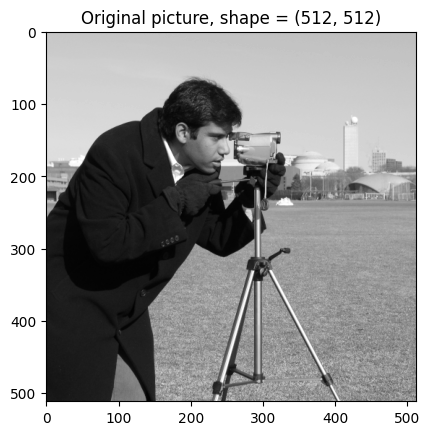

In [ ]:
import skimage.data

x = skimage.data.camera()

plt.imshow(x, cmap="gray")
plt.title(f"Original picture, shape = {x.shape}")
plt.show()

U, s, Vh = np.linalg.svd(x)

 2. Visualize some of the dyad $σ_iu_iv_i^T$ of this decomposition. What do you notice?


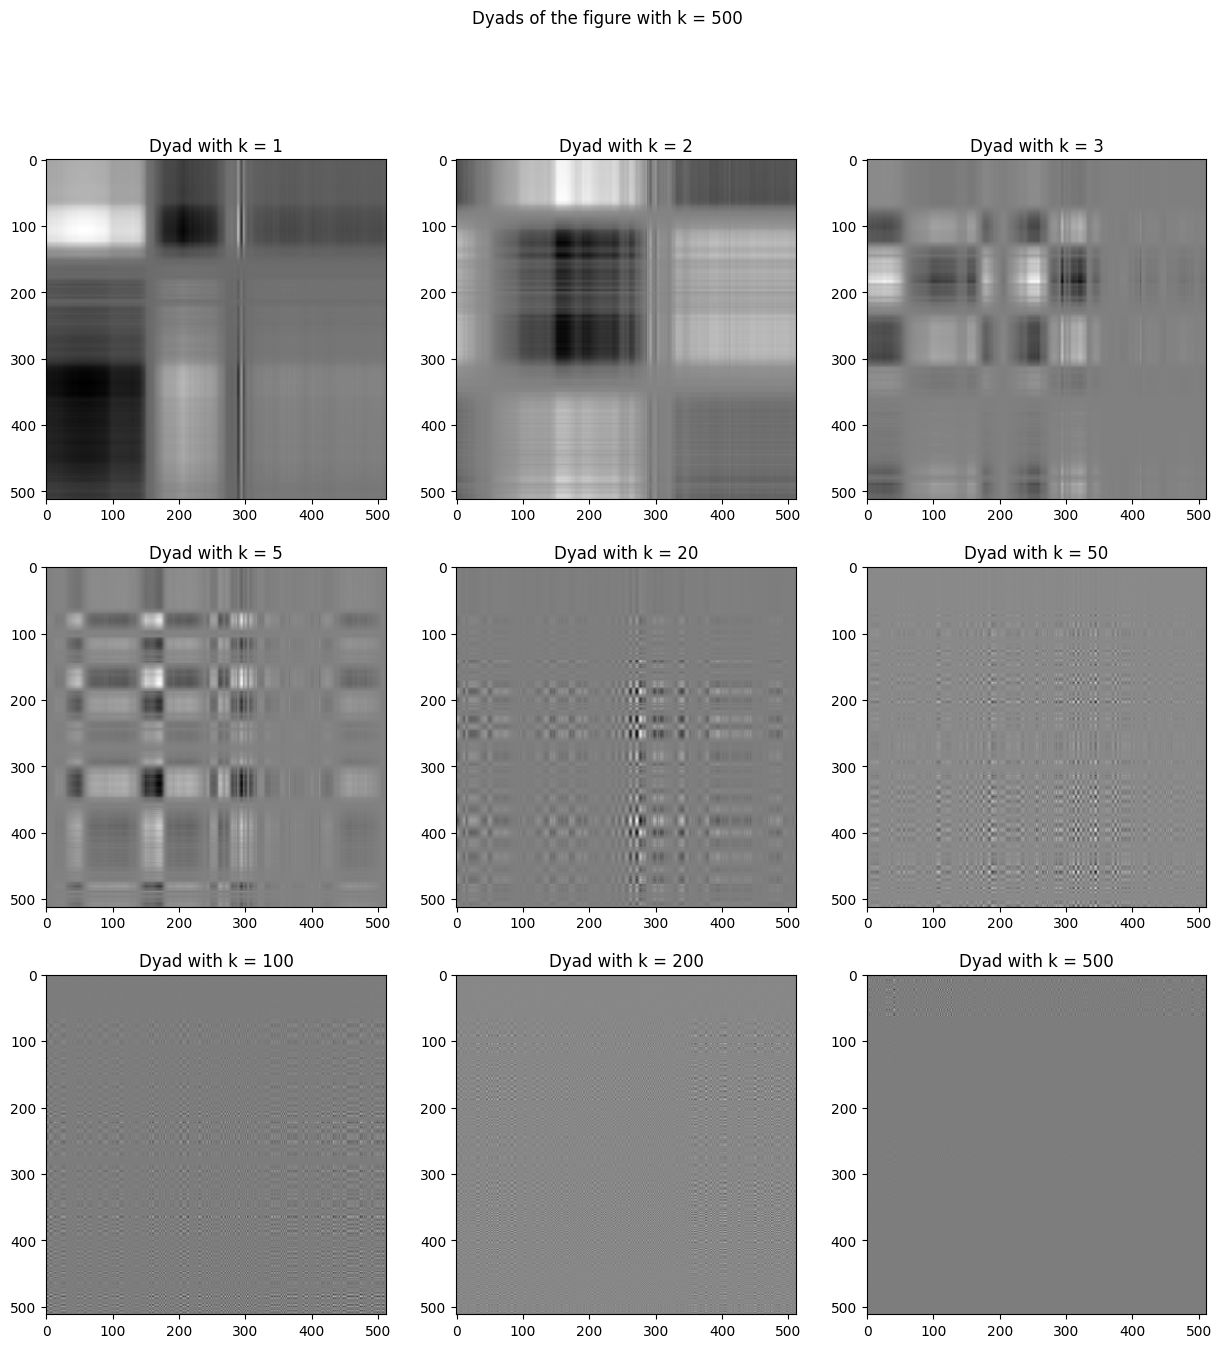

In [ ]:
k_to_test = [1, 2, 3, 5, 20, 50, 100, 200, 500]
dyads = []

for k in k_to_test:
  dyads.append(np.dot(U[:,k].reshape([U.shape[0],1]), Vh[k,:].reshape([1,Vh.shape[0]]))*s[k])

plt.figure(figsize=(15, 15))
plt.suptitle(f"Dyads of the figure with k = {k}")

for i in range(len(k_to_test)):
  fig = plt.subplot(3, 3, i+1)
  fig.imshow(dyads[i], cmap='gray')
  plt.title('Dyad with k = ' + str(k_to_test[i]))

plt.show()

If we consider the singular values in the s matrix as the "importance" of the singular vectors in the decomposition, a dyad can be seen as the outer product of a pair of singular vectors, and it can be used to explain how each singular value contributes to the overall structure of the original matrix X. Since, by convention, the singular values are ordered by descending order of magnitude, a dyad with $k = 1$ (alone) will be the one that more closely resembles the original image, even though it will not retain any details from it.

Sum of the dyads computed with the following k: [1, 2, 3, 5, 20, 50, 100, 200, 500]



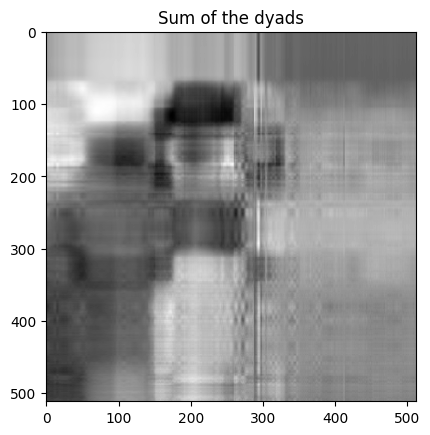

In [ ]:
sum_dyads = np.zeros(dyads[0].shape)
for dyad in dyads:
  sum_dyads = sum_dyads + dyad

print(f"Sum of the dyads computed with the following k: {k_to_test}\n")
fig = plt.imshow(sum_dyads)
fig = plt.imshow(sum_dyads, cmap = "gray")
plt.title("Sum of the dyads")
plt.show()

 3. Plot the singular values of X. Do you note something?


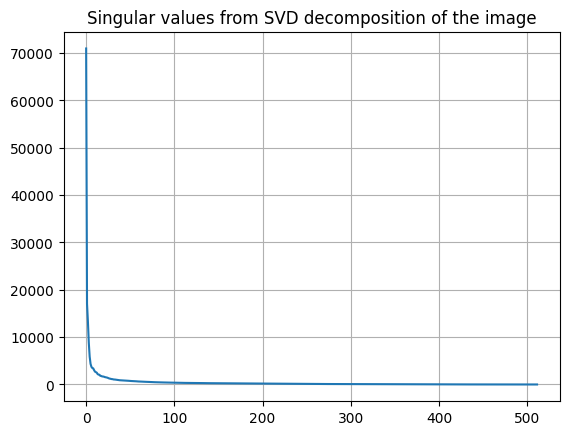

In [ ]:
plt.title("Singular values from SVD decomposition of the image")

plt.grid()
plt.plot(s)
plt.show()

For increasing values of k singular values ($σ_k$) start high and then decline rapidly, eventually leveling off. This initial steep drop reflects the fact that the first few singular values capture the most significant portion of the variance in the data.

 4. Visualize the k-rank approximation of X for erent values of k. What do you observe?


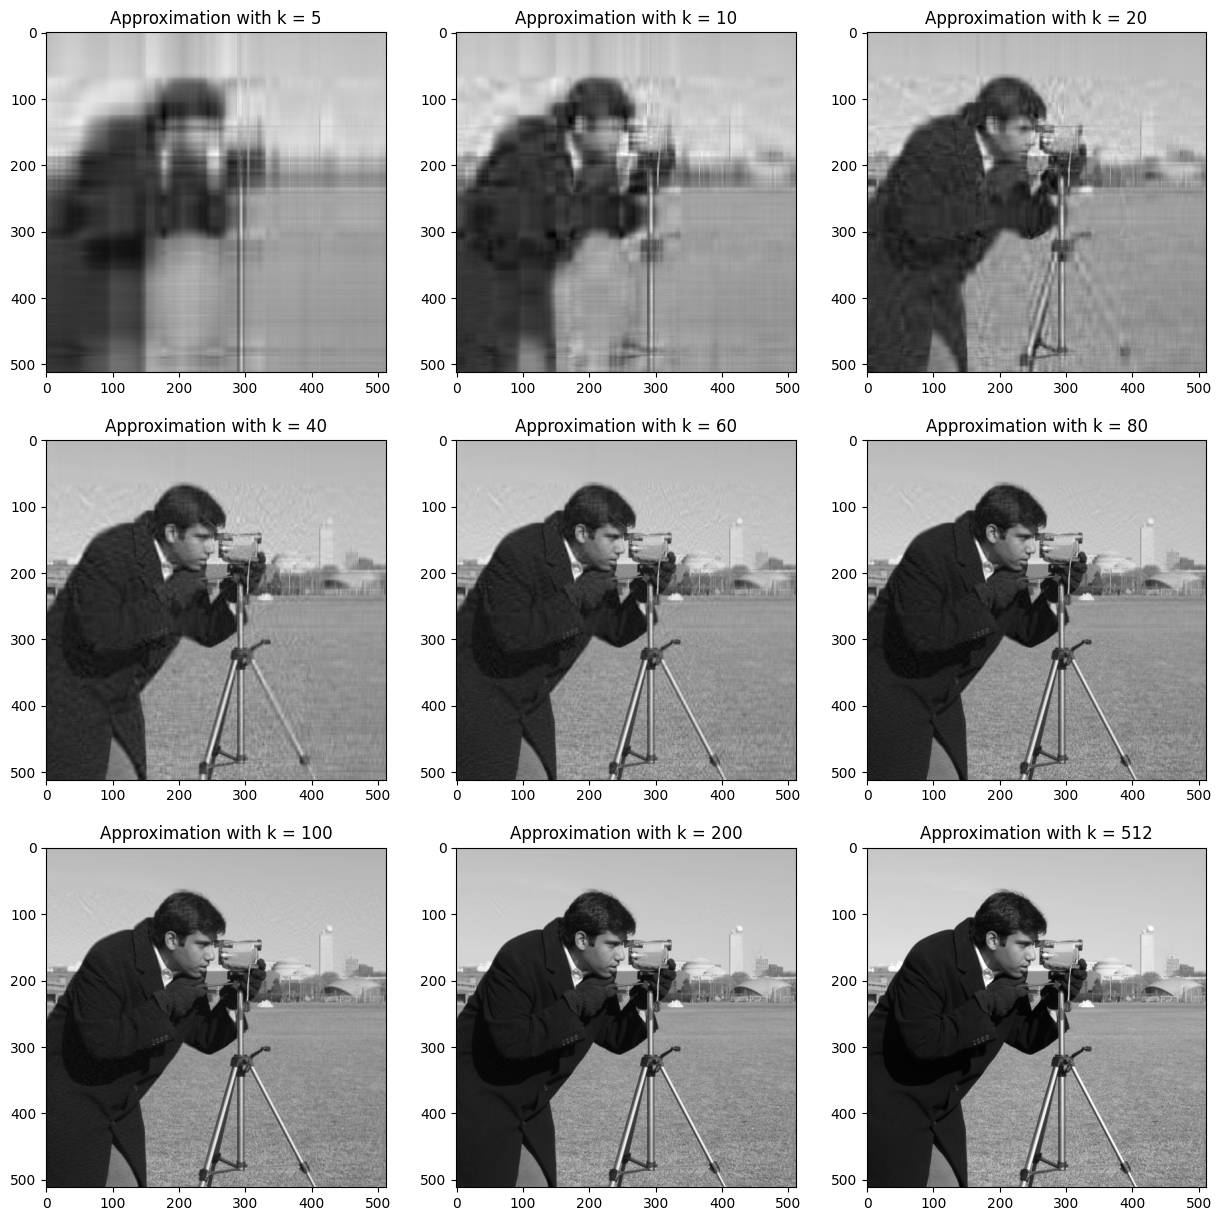

In [ ]:
k_to_test = [5, 10, 20, 40, 60, 80, 100, 200, 512]

dyads = []
for i in range(512):
  dyads.append(np.dot(U[:,i].reshape([U.shape[0],1]), Vh[i,:].reshape([1,Vh.shape[0]]))* s[i])
approx = {value: np.zeros(dyads[0].shape) for value in k_to_test}

for value in k_to_test:
  sum_dyads = np.zeros(dyads[0].shape)
  for dyad in np.array(dyads)[:value, :, :]:
    sum_dyads = sum_dyads + dyad
  approx[value] = approx[value]+sum_dyads

i = 0
plt.figure(figsize=(15, 15))
for value in k_to_test:
  fig = plt.subplot(3, 3, i+1)
  fig.imshow(approx[value], cmap='gray')
  plt.title('Approximation with k = ' + str(k_to_test[i]))
  i = i+1

plt.show()

We can observe that:

- **Low k values** (5, 10, 20) will provide very rough approximations. Major features of the image are recognizable, but details are lost. This is due to the fact that, as we stated above, the first dyads (small ks) are those who contain most information.

- **Medium k values** (40, 60, 80): The image quality improves noticeably. More details will be visible, and the images  starts to resemble the original more closely. However, some fine details are still missing.

- **High k values** (100, 200): The approximations are very close to the original image, with most of the details preserved.

- **k = 512**: At this point, the approximation is identical to the original image, as all singular values are used.


 5. Compute and plot the approximation error $||X-X_k||$ for increasing values of k, where $X_k$ is the k-rank approximation of k.


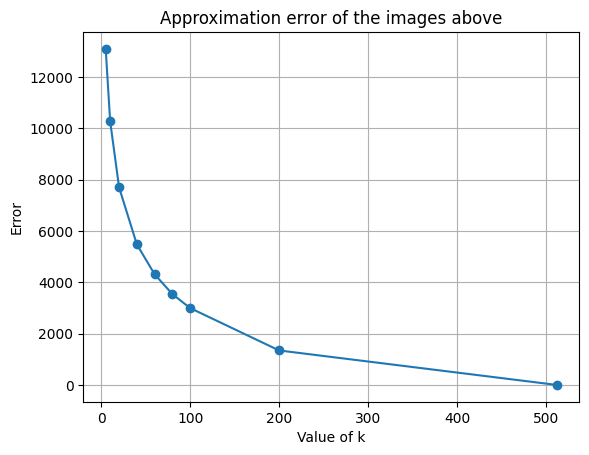

In [ ]:
approx_err = []

for i in k_to_test:
  approx_err.append(np.linalg.norm(x - approx[i]))

plt.title('Approximation error of the images above')
plt.grid()
plt.xlabel("Value of k")
plt.ylabel("Error")
plt.plot(k_to_test, approx_err, marker = 'o')

plt.show()


The approximation error follows a similar trend to the singular values, since, with increasing values of k, the approximated image retains more and more fine details, until it perfectly resembles the original one.

 6. Plot the compression factor for increasing k.

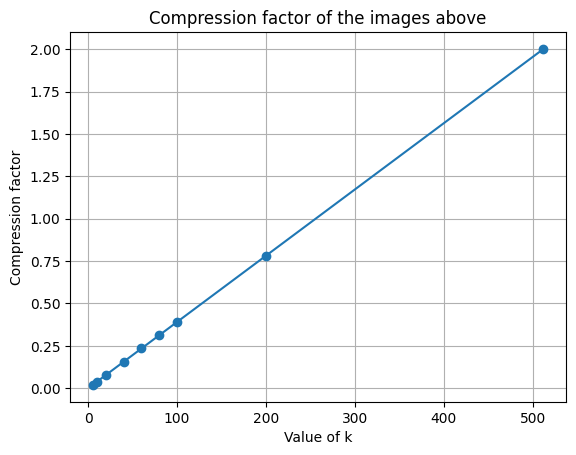

In [ ]:
m,n = x.shape

compress_fact = [(k*(m+n+1))/(m*n) for k in k_to_test]

plt.title('Compression factor of the images above')
plt.grid()
plt.xlabel("Value of k")
plt.ylabel("Compression factor")
plt.plot(k_to_test, compress_fact, marker = 'o')

plt.show()

The number of values required to memorize the approximation $X_k$ is $k(m+n+1)$ while the number of values required to memorize the whole image is $(mn)$. The compression factor is the ratio between these two values. As we can observe, for small values of $k$, this ratio is low, indicating that only a small fraction of the original matrix's information is being stored. While higher values of $k$ result in exceeding 1, indicating that more memory is required for the approximated image with respect to the original one.